In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

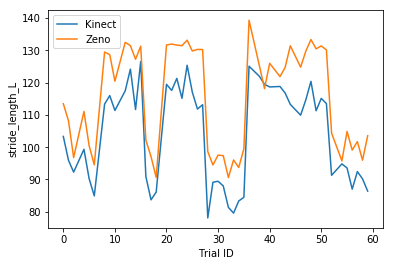

In [3]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

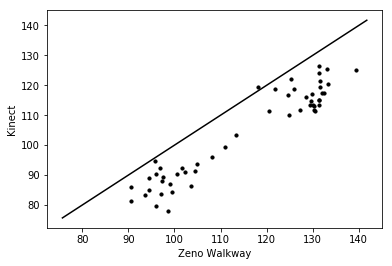

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_L'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

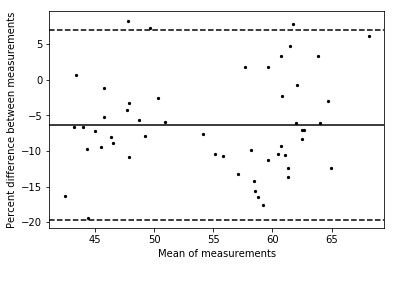

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,absolute_step_length_L,absolute_step_length_R,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.883557,0.962816,0.877976,0.955908,0.950068,0.968790,0.878195,0.853061,0.960850,0.899160,0.782512,0.893891
Spearman,0.822846,0.859046,0.824212,0.856655,0.868095,0.893940,0.724252,0.604714,0.876206,0.813455,0.669513,0.820541
Abs rel error,0.071448,0.099835,0.077448,0.108245,0.098683,0.088212,0.164434,0.144597,0.076325,0.090249,2.300839,1.787879
Bias,-0.060030,-0.104937,-0.063435,-0.112265,-0.104320,-0.092699,-0.171855,-0.133801,0.023199,-0.013011,0.285287,0.882704
Range,0.248659,0.134102,0.267489,0.155511,0.181226,0.136698,0.522655,0.530269,0.338652,0.453434,4.920418,14.875357


In [7]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,absolute_step_length,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.969807,0.963087,0.972461,0.906549,0.954419,0.903544
Spearman,0.865107,0.871340,0.893708,0.666738,0.849483,0.809784
Abs rel error,0.078575,0.085061,0.093223,0.140414,0.064629,1.126117
Bias,-0.082236,-0.087618,-0.098298,-0.149903,0.007218,0.004572
Range,0.120656,0.138980,0.129670,0.429044,0.316067,11.367919


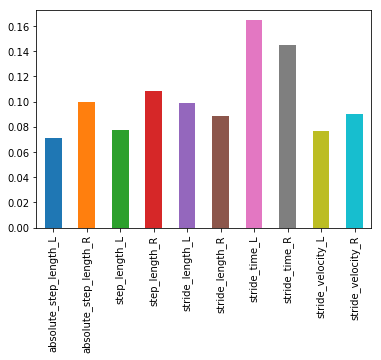

In [8]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [9]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.888860,0.922271
Spearman,0.797521,0.808059
Abs rel error,0.464863,0.386503
Bias,-0.015192,0.070999
Range,1.079850,2.714228


In [10]:
df_grouped.stride_length * 100

Pearson          97.246147
Spearman         89.370785
Abs rel error     9.322274
Bias             -9.829784
Range            12.967029
Name: stride_length, dtype: float64

In [11]:
df_rel_error = abs(df_k - df_z) / df_z * 100

In [12]:
max_idx = df_rel_error.stride_length_L.idxmax()